In [ ]:
!pip install arcticdb

In [1]:
import numpy as np
import pandas as pd
import arcticdb as adb

<center>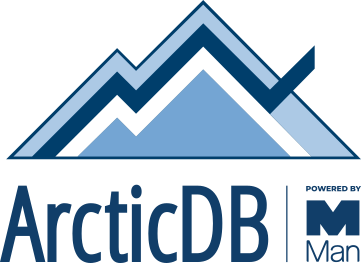
</center>

# ArcticDB Concat Demo

This demo notebook showcases the first symbol joining capability within ArcticDB, concatenation.

This is what you need to know about it:

* It runs on-the-fly as part of the read
* The usage and results are similar to the Pandas concat function (although not identical, differences are highlighted below)
* Processing before and after the concat operation are parallelised like all other processing in ArcticDB, leading to potentially large performance improvements compared to concatenating and processing in Pandas

## Setup

In [2]:
# object store
arctic = adb.Arctic("lmdb://arcticdb_concat")

In [3]:
# library
lib = arctic.get_library('concat', create_if_missing=True)
lib._nvs.version_store.clear() # TODO: Remove after clean run gets nice version numbers in output

## Create Some Data

* 3 symbols, each with 10,000,000 rows
* int, float, string columns
* write the data into ArcticDB

In [4]:
# data for concatenating
num_symbols = 3
rows_per_symbol = 10_000_000
dfs = []
for _ in range(num_symbols):
    int_data = np.arange(rows_per_symbol, dtype=np.int64)
    float_data = np.round(np.random.uniform(95., 105., rows_per_symbol), 3)
    letters = ['a','b','c','d','e','f','g']
    dfs.append(pd.DataFrame(
        {
            "int": int_data,
            "float": float_data,
            "string": (letters*(rows_per_symbol//len(letters) + 1))[:rows_per_symbol]
        }
    ))

In [5]:
# view the first 10 rows of one of the dataframes
dfs[0].head(10)

,int,float,string
0,0,98.089,a
1,1,98.086,b
2,2,103.995,c
3,3,98.736,d
4,4,104.769,e
5,5,96.473,f
6,6,103.227,g
7,7,99.624,a
8,8,100.271,b
9,9,102.942,c


In [6]:
symbols = [f"sym_{idx}" for idx in range(num_symbols)]
write_payloads = []
for idx in range(num_symbols):
    write_payloads.append(adb.WritePayload(symbols[idx], dfs[idx], {"my_metadata": idx}))
lib.write_batch(write_payloads)

[VersionedItem(symbol='sym_0', library='concat', data=n/a, version=0, metadata={'my_metadata': 0}, host='LMDB(path=/users/is/aowens/source/man.arcticdb/arcticdb_link/docs/mkdocs/docs/notebooks/arcticdb_concat)', timestamp=1747668401594375351),
 VersionedItem(symbol='sym_1', library='concat', data=n/a, version=0, metadata={'my_metadata': 1}, host='LMDB(path=/users/is/aowens/source/man.arcticdb/arcticdb_link/docs/mkdocs/docs/notebooks/arcticdb_concat)', timestamp=1747668401581112132),
 VersionedItem(symbol='sym_2', library='concat', data=n/a, version=0, metadata={'my_metadata': 2}, host='LMDB(path=/users/is/aowens/source/man.arcticdb/arcticdb_link/docs/mkdocs/docs/notebooks/arcticdb_concat)', timestamp=1747668401617289932)]

## 1. Simple Concat

Concatenate the symbols together without any additional arguments or processing

In [7]:
lazy_dfs = lib.read_batch(symbols, lazy=True)
lazy_df = adb.concat(lazy_dfs)
result = lazy_df.collect()
type(result)

arcticdb.version_store._store.VersionedItemWithJoin

The resulting object contains the version information and metadata associated with the symbol-version pairs that have been concatenated together

In [8]:
result.versions[1]

VersionedItem(symbol='sym_1', library='concat', data=n/a, version=0, metadata={'my_metadata': 1}, host='LMDB(path=/users/is/aowens/source/man.arcticdb/arcticdb_link/docs/mkdocs/docs/notebooks/arcticdb_concat)', timestamp=1747668401581112132)

The `data` field of the returned object contains the concatenated dataframe (note there are 30 million rows in the output)

In [9]:
result.data

,int,float,string
0,0,98.089,a
1,1,98.086,b
2,2,103.995,c
3,3,98.736,d
4,4,104.769,e
...,...,...,...
29999995,9999995,101.851,f
29999996,9999996,98.617,g
29999997,9999997,99.181,a
29999998,9999998,102.034,b


## 2. Concat with pre and post processing

Perform processing operations both before and after the concatenation. See the `LazyDataFrame` demo notebook for more explanation of the available operations and how to apply different pre-processing to each symbol

In [10]:
lazy_dfs = lib.read_batch(symbols, lazy=True)
lazy_dfs = lazy_dfs[lazy_dfs["string"] != "a"]
lazy_df = adb.concat(lazy_dfs)
lazy_df["new_col"] = lazy_df["float"] * 2
lazy_df.collect().data

,int,float,string,new_col
0,1,98.086,b,196.172
1,2,103.995,c,207.990
2,3,98.736,d,197.472
3,4,104.769,e,209.538
4,5,96.473,f,192.946
...,...,...,...,...
25714279,9999994,100.683,e,201.366
25714280,9999995,101.851,f,203.702
25714281,9999996,98.617,g,197.234
25714282,9999998,102.034,b,204.068


### Note the output index above

It is a `RangeIndex` with start 0 and step 1. This is in contrast to Pandas, which would return an `Int64Index` in this case. This is because most data in ArcticDB with a `RangeIndex` isn't really indexed at all. Different step values will be respected if they match across all symbols being concatenated, with the start value being taken from the first symbol:

In [11]:
lib.write_batch([adb.WritePayload("range_indexed_0", pd.DataFrame({"col": [0, 1]}, index=pd.RangeIndex(3, 7, 2))), adb.WritePayload("range_indexed_1", pd.DataFrame({"col": [2, 3]}, index=pd.RangeIndex(0, 4, 2)))])
adb.concat(lib.read_batch(["range_indexed_0", "range_indexed_1"], lazy=True)).collect().data

,col
3,0
5,1
7,2
9,3


Otherwise, a warning is logged, and the resulting dataframe has a `RangeIndex` with start 0 and step 1:

In [12]:
lib.write_batch([adb.WritePayload("range_indexed_2", pd.DataFrame({"col": [0, 1]}, index=pd.RangeIndex(3, 7, 2))), adb.WritePayload("range_indexed_3", pd.DataFrame({"col": [2, 3]}, index=pd.RangeIndex(0, 6, 3)))])
adb.concat(lib.read_batch(["range_indexed_2", "range_indexed_3"], lazy=True)).collect().data

20250519 16:26:55.537708 3411651 W arcticdb | Mismatching RangeIndexes being combined, setting to start=0, step=1


,col
0,0
1,1
2,2
3,3


## 3. Inner Joins

* In the examples above, all of the input dataframes have the same column names and dtypes, and no arguments have been provided to `adb.concat` beyond the list of lazy dataframes to be concatenated.
* `adb.concat` takes an additional argument `join`, which should be one of `"inner"` or `"outer"` (default is `"outer"`), which dictates whether to take the intersection (inner) or union (outer) of columns from the input symbols.
* If the dtypes of columns being joined together do not match exactly, then type promotion to a common type will occur if such a type exists.

### Use inner join to retain only columns present in **all** input symbols

* Only columns `b` and `c` are present in all of the input symbols
* The ordering of the output columns is taken from the first symbol (`inner_0` in this case)

In [13]:
lib.write("inner_0", pd.DataFrame({"a": [0], "b": [0], "c": [0], "d": [0]}))
lib.write("inner_1", pd.DataFrame({"c": [1], "b": [1], "e": [1]}))
lib.write("inner_2", pd.DataFrame({"f": [2], "b": [2], "c": [2], "d": [0]}))
lazy_dfs = lib.read_batch(["inner_0", "inner_1", "inner_2"], lazy=True)
adb.concat(lazy_dfs, join="inner").collect().data

,b,c
0,0,0
1,1,1
2,2,2


### Types are promoted to a valid common type where possible, or an exception is thrown if not

In [14]:
lib.write("type_promotion_uint16", pd.DataFrame({"a": np.arange(0, 1, dtype=np.uint16)}))
lib.write("type_promotion_int16", pd.DataFrame({"a": np.arange(3, 4, dtype=np.int16)}))
lib.write("type_promotion_int64", pd.DataFrame({"a": np.arange(4, 5, dtype=np.int64)}))
lib.write("type_promotion_float64", pd.DataFrame({"a": np.arange(4, 5, dtype=np.float64)}))
lib.write("type_promotion_str", pd.DataFrame({"a": ["hello"]}))

VersionedItem(symbol='type_promotion_str', library='concat', data=n/a, version=0, metadata=None, host='LMDB(path=/users/is/aowens/source/man.arcticdb/arcticdb_link/docs/mkdocs/docs/notebooks/arcticdb_concat)', timestamp=1747668420389905134)

In [15]:
# int32 can represent all of the values in both the uint16 and int16 dtypes
lazy_dfs = lib.read_batch(["type_promotion_uint16", "type_promotion_int16"], lazy=True)
adb.concat(lazy_dfs).collect().data["a"].dtype

dtype('int32')

In [16]:
# float64 cannot represent all of the values in the int64 dtype, but it is the best we can do
lazy_dfs = lib.read_batch(["type_promotion_int64", "type_promotion_float64"], lazy=True)
adb.concat(lazy_dfs).collect().data["a"].dtype

dtype('float64')

In [17]:
# There is no sensible type we can use to combine string and numeric columns, so we throw in this case
lazy_dfs = lib.read_batch(["type_promotion_int64", "type_promotion_str"], lazy=True)
try:
    adb.concat(lazy_dfs).collect().data["a"].dtype
except adb.exceptions.SchemaException as e:
    print(e)

E_DESCRIPTOR_MISMATCH No common type between INT64 and UTF_DYNAMIC64 when joining schemas


## 4. Outer Joins

* The same type promotion rules apply with outer joins as with inner joins
* Missing columns are backfilled with the same type-specific values as with dynamic schema:
    * strings: None
    * floats: NaN
    * integers: 0

Note that the behaviour with integers is different to Pandas, which changes the type of the column to `float64` and then fills in the missing values with NaNs

In [18]:
lib.write("missing_columns_0", pd.DataFrame({"string": ["hello"], "float": [0.5], "int": [0]}))
lib.write("missing_columns_1", pd.DataFrame({"another string": ["goodbye"], "another float": [1.5], "another int": [1]}))
lazy_dfs = lib.read_batch(["missing_columns_0", "missing_columns_1"], lazy=True)
adb.concat(lazy_dfs, join="outer").collect().data

,string,float,int,another string,another float,another int
0,hello,0.5,0,None,NaN,0
1,None,NaN,0,goodbye,1.5,1


## Permissiveness

Where possible, we allow joining symbols together whenever it is sensible to do so

### Joining Series together will maintain the name if it is the same between all of the input symbols, and return an unnamed Series otherwise

In [19]:
lib.write("series_0", pd.Series([0], name="Name 0"))
lib.write("series_1", pd.Series([1], name="Name 0"))
lib.write("series_2", pd.Series([2], name="Name 2"))

VersionedItem(symbol='series_2', library='concat', data=n/a, version=0, metadata=None, host='LMDB(path=/users/is/aowens/source/man.arcticdb/arcticdb_link/docs/mkdocs/docs/notebooks/arcticdb_concat)', timestamp=1747668429668528542)

In [20]:
lazy_dfs = lib.read_batch(["series_0", "series_1"], lazy=True)
adb.concat(lazy_dfs).collect().data

0    0
1    1
Name: Name 0, dtype: int64

In [21]:
lazy_dfs = lib.read_batch(["series_0", "series_1", "series_2"], lazy=True)
adb.concat(lazy_dfs).collect().data

0    0
1    1
2    2
dtype: int64

### Similarly, joining timeseries together will maintain the index name if it is the same between all of the input symbols, and return a dataframe with an unnamed index otherwise

In [22]:
lib.write("timeseries_0", pd.DataFrame({"col": [0]}, index=pd.DatetimeIndex([pd.Timestamp("2025-01-01")], name="timestamp")))
lib.write("timeseries_1", pd.DataFrame({"col": [1]}, index=pd.DatetimeIndex([pd.Timestamp("2025-01-01")], name="timestamp")))
lib.write("timeseries_2", pd.DataFrame({"col": [2]}, index=pd.DatetimeIndex([pd.Timestamp("2025-01-01")])))

VersionedItem(symbol='timeseries_2', library='concat', data=n/a, version=0, metadata=None, host='LMDB(path=/users/is/aowens/source/man.arcticdb/arcticdb_link/docs/mkdocs/docs/notebooks/arcticdb_concat)', timestamp=1747668433533639018)

In [23]:
lazy_dfs = lib.read_batch(["timeseries_0", "timeseries_1"], lazy=True)
adb.concat(lazy_dfs).collect().data

,col
timestamp,
2025-01-01,0
2025-01-01,1


In [24]:
lazy_dfs = lib.read_batch(["timeseries_0", "timeseries_1", "timeseries_2"], lazy=True)
adb.concat(lazy_dfs).collect().data

,col
2025-01-01,0
2025-01-01,1
2025-01-01,2


## Conclusion

We have demonstrated the following about the ArcticDB concat feature:

* Easy to use, especially if you already concat in Pandas
* Can be combined with other query functions to build processing pipelines
* When more query functions are applied post-concat, will be more performant than Pandas due to ArcticDB's parallel processing implementation